In [1]:
import pandas as pd
import numpy as np

from models import *
from series_restr import *
from utils import *

c:\Anaconda3\envs\torch37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
df = pd.read_excel('data/df_eu.xlsx', sheet_name='df-eu')

Xcols = ['Eprice', 'BrentOil', 'CrudeOilF', 'TTF-NatGas', 'NatGasF', 'Coal', 'GasolineF', 'DJI', 'S&P500', 'USD-EUR']
dataX = np.array(df[Xcols]) 
dataY = np.array(df['Cprice']).reshape(-1,1)

print(dataX.shape)
print(dataY.shape)

(1305, 10)
(1305, 1)


1.6642432966693453e-14
1.563246609334534e-14


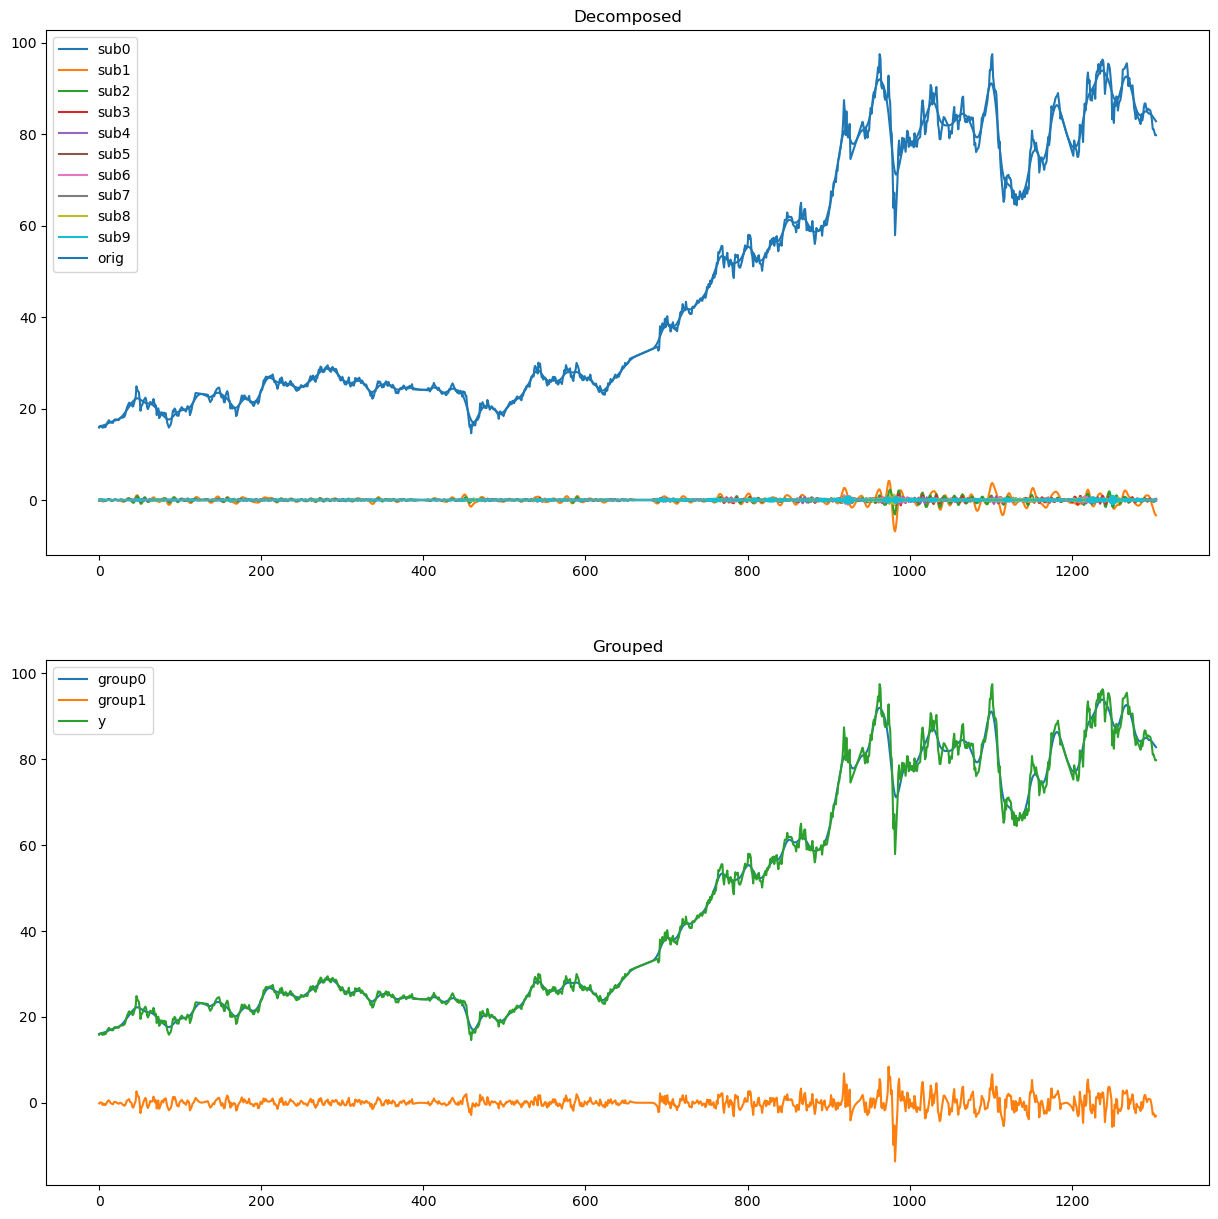

In [7]:
reconstr = restr_ssa(dataY.reshape(-1), n_decomp=10, n_integr=2, vis=True)

In [10]:
reconstr.shape

(2, 1305)

In [13]:
batch_size = 1
pred_len = 10
seq_len = 100

pred = np.zeros((reconstr.shape[1]-seq_len-pred_len+1, pred_len))
real = np.zeros((reconstr.shape[1]-seq_len-pred_len+1, pred_len))

batch_size = 1
for i in range(reconstr.shape[0]):
    print(i)
    subY = reconstr[i,:].reshape(-1,1)
    m = TCN_model('sg-nowin-TCN'+str(i), batch_size)
    m.prepare_data(dataX, subY, seq_len=100, pred_len=10)
    m.init_model()
    m.train_model(train_ratio=1, val_ratio=0.2)
    # m.load_model()
    sub_pred, sub_real = m.test_model(test_ratio=1)
    pred += sub_pred
    real += sub_real

0
epoch 001 train_loss 0.00540458 val_loss 0.00446478
epoch 002 train_loss 0.00481594 val_loss 0.00380728
epoch 003 train_loss 0.00546801 val_loss 0.00479815
EarlyStopping counter: 1 out of 7
epoch 004 train_loss 0.00482735 val_loss 0.00328973
epoch 005 train_loss 0.00559781 val_loss 0.00544284
EarlyStopping counter: 1 out of 7
epoch 006 train_loss 0.00478804 val_loss 0.00440359
EarlyStopping counter: 2 out of 7
epoch 007 train_loss 0.00482228 val_loss 0.00649850
EarlyStopping counter: 3 out of 7
epoch 008 train_loss 0.00490657 val_loss 0.00436338
EarlyStopping counter: 4 out of 7
epoch 009 train_loss 0.00461117 val_loss 0.00346360
EarlyStopping counter: 5 out of 7
epoch 010 train_loss 0.00409098 val_loss 0.00312293
epoch 011 train_loss 0.00478479 val_loss 0.00472304
EarlyStopping counter: 1 out of 7
epoch 012 train_loss 0.00492880 val_loss 0.00397971
EarlyStopping counter: 2 out of 7
epoch 013 train_loss 0.00411815 val_loss 0.00445657
EarlyStopping counter: 3 out of 7
epoch 014 train_

performance of hb-nowin-TCN
col 0: RMSE=2.39, MAPE=3.60%
col 1: RMSE=2.37, MAPE=3.57%
col 2: RMSE=2.37, MAPE=3.59%
col 3: RMSE=2.43, MAPE=3.73%
col 4: RMSE=2.42, MAPE=3.79%
col 5: RMSE=2.46, MAPE=3.91%
col 6: RMSE=2.45, MAPE=3.97%
col 7: RMSE=2.50, MAPE=4.09%
col 8: RMSE=2.60, MAPE=4.24%
col 9: RMSE=2.68, MAPE=4.35%


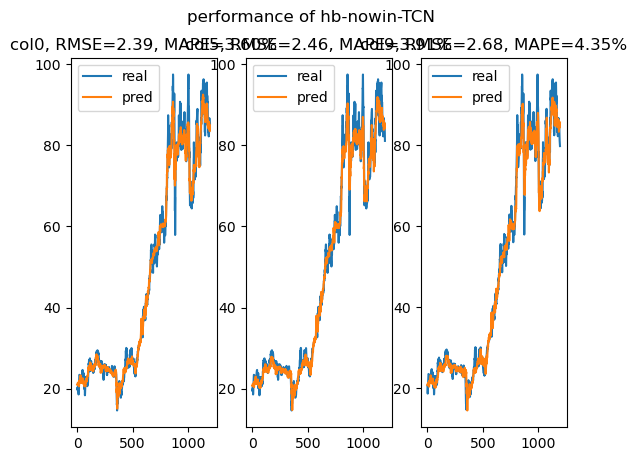

In [14]:
show_performance('hb-nowin-TCN', pred, real, vis=True)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
 
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)
 
model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore', 
                      suppress_warnings=True,
                      stepwise=True)
 
print(model.summary())
 
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df.value), len(df.value)+n_periods)
 
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)
 
# Plot
plt.plot(df.value)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index,
                 lower_series,
                 upper_series,
                 color='k', alpha=.15)
 
plt.title("Final Forecast of WWW Usage")
plt.show()